## Walmart Sales  


In [5]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor ,RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score ,classification_report, confusion_matrix ,mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor , XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder ,MinMaxScaler
#import tensorflow as tf
#from tensorflow.keras import layers, models, Input
#from tensorflow.keras.callbacks import EarlyStopping

In [6]:
df =pd.read_csv("walmart-sales-dataset-of-45stores.csv")
df.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [8]:
print(f"The dataset has {df.shape[0]} Rows and {df.shape[1]} columns")

The dataset has 6435 Rows and 8 columns


In [9]:
df.isna().sum()       # the dataset doesnt have null values

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [10]:
df.duplicated().sum()   # it doesnt have duplicates

np.int64(0)

In [11]:
df.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

In [12]:
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.dtypes                                       ### changed the format of the Date in order to explore it further

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

# EDA


In [13]:
fig = make_subplots(rows=5, cols=1, subplot_titles=[
    "Distribution of Temperature",
    "Distribution of Fuel Price",
    "Distribution of Unemployment",
    "Distribution of CPI",
    "Distribution of Weekly_Sales"
])

features = ['Temperature', 'Fuel_Price', 'Unemployment', 'CPI', 'Weekly_Sales']
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A8', '#A833FF']

for i, feature in enumerate(features):
    fig.add_trace(
        go.Histogram(x=df[feature], marker=dict(color=colors[i])),
        row=i+1, col=1
    )


fig.update_layout(
    title_text="Feature Distributions",
    template="plotly_dark",
    showlegend=False,
    height=1500,
    font=dict(size=14),
    title_font=dict(size=20),
    plot_bgcolor="rgba(0,0,0,0)"
)

fig.show()


### ⛽ Fuel Price Distribution  
- Fuel prices mostly range between **$2.5 and $4.5**.  
- This might mean fuel prices fluctuated a lot over time.  

### 📉 Unemployment Distribution  
- Most unemployment rates are between **4% and 12%**, with a lot of values around **7% - 9%**.  
- The peak here suggests that many areas had similar employment conditions.  

### 📈 CPI (Consumer Price Index) Distribution  
- This one has two peaks—one around **130** and another around **210**.   
- The big jump could be due to major price changes, like economic shifts or policy changes.  

#### Final Thoughts  
CPI seems to show inflation pretty clearly, and fuel prices also changed a lot. Unemployment mostly stayed within a range, but there were some higher values too.

---



In [14]:
features = ["Temperature", "Fuel_Price", "Unemployment", "CPI", "Weekly_Sales"]

fig = make_subplots(rows=len(features), cols=1, subplot_titles=[f"Outliers in {feature}" for feature in features])


for i, feature in enumerate(features):
    fig.add_trace(
        go.Box(y=df[feature], boxpoints="outliers", marker=dict(color="cyan")),
        row=i+1, col=1
    )

fig.update_layout(
    title_text="Outlier Detection Across Features",
    template="plotly_dark",
    height=1500,
    showlegend=False
)

fig.show()


#### **1. Unemployment**
- A few outliers above 10% suggest some periods of unusually high unemployment.
- These may be from economic downturns or specific events.

#### **2. CPI (Consumer Price Index)**
- No extreme outliers, but a wide range of values.
- This indicates inflation changes over time.

#### **3. Weekly Sales**
- Some extreme outliers exist, especially on the higher end.
- These might be due to holiday sales or special promotions.

---

In [15]:
fig = px.histogram(
    df,
    x='Weekly_Sales',
    nbins=50,
    title="Distribution of Weekly Sales",
    template='plotly_dark'
)

fig.update_layout(
    xaxis_title='Weekly Sales',
    yaxis_title='Count',
    height=400,
    bargap=0.1
)

fig.show()

### 📊 Insights: Weekly Sales Distribution

- Most weekly sales are between **$400K and $1.5M**.
- The peak frequency is around **$600K**.
- As sales increase, the number of stores with high weekly sales **drops sharply**.
- Very few stores have weekly sales over **$2.5M**.
- The distribution is **right-skewed**, meaning high sales are rare.



In [16]:
data_by_store = df.groupby("Store").mean()
fig = px.bar(data_by_store,
             x=data_by_store.index,
             y='Weekly_Sales',
             labels={'x': 'Store ID', 'Weekly_Sales': 'Amount'},
             title="Sales by Store")
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(color='white'),
    xaxis_title='Store ID',
    yaxis_title='Amount',

)

fig.show()


#### Store 20 has the highest sales of all the store , while store 33 has the lowest .


----

## The relation between temperature and the weekly sales

In [17]:
fig = px.scatter(
    df,
    x='Temperature',
    y='Weekly_Sales',
    color='Store',
    color_continuous_scale='viridis',
    title="Temperature vs Weekly Sales",
    labels={'Temperature': 'Temperature (°F)', 'Weekly_Sales': 'Weekly Sales ($)'},
    template='plotly_dark',
    hover_data=['Store']
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20),
    coloraxis_colorbar=dict(title="Store ID"),
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.show()


- **At temperature 0 to 20 the weekly_sales is low at all stores ,and temperature from 20 to 100 weekly_sales are normal and at stores 35 to 45 weekly_sales are low and at stores from 1 to 15 the weekly_sales are high**

- **Negative Correlation**: As temperature increases, weekly sales tend to decrease, indicating that lower temperatures may drive more sales.  
- **Higher Sales Concentration**: Most stores have weekly sales below $1M, with only a few reaching above $2M.   
- **Outliers**: Some stores experience extremely high sales even at low temperatures, which could indicate special events, promotions, or seasonal effects.  

---


## The relation between Unemployment and the Stores

In [18]:
import plotly.express as px

fig = px.bar(
    df,
    x='Store',
    y='Unemployment',
    title="Unemployment Rate by Store",
    labels={'Store': 'Store ID', 'Unemployment': 'Unemployment Rate (%)'},
    template='plotly_dark',
    color='Unemployment',
    color_continuous_scale='viridis'
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20),
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(tickangle=-45)
)

fig.show()


**At stores 12 ,28 and 38 have heigher number of unemployment and stores 23 and 40 have lower number of unemployement**

---

## The relation between weekly_sales and fuel_price with store

In [19]:
import plotly.express as px

fig = px.scatter(
    df,
    x='Fuel_Price',
    y='Weekly_Sales',
    color='Store',
    size='Weekly_Sales',
    title="Weekly Sales vs Fuel Prices Across Stores",
    labels={'Fuel_Price': 'Fuel Price ($)', 'Weekly_Sales': 'Weekly Sales ($)', 'Store': 'Store ID'},
    template='plotly_dark',
    color_continuous_scale='jet',
    hover_data=['Store']
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20),
    coloraxis_colorbar=dict(title="Store ID")
)

fig.show()


**weekly_sales  increase when fuel_price is from 2.7 to 3.5 and stores 1 to 15 have the highest weekly_sales .**

**A few stores experience **higher sales spikes**, even at varying fuel price points.**

---

## The relation beween cpi and weekly sales

In [20]:
fig = px.scatter(
    df,
    x='CPI',
    y='Weekly_Sales',
    color='Store',
    color_continuous_scale='agsunset',
    title="CPI vs Weekly Sales",
    labels={'CPI': 'CPI', 'Weekly_Sales': 'Weekly Sales ($)'},
    template='plotly_dark',
    hover_data=['Store']
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20),
    coloraxis_colorbar=dict(title="Store ID"),

)

fig.show()



- **CPI clusters** (120-150, 180-200, 210-230) suggest regional or time-based differences.  
- **Most sales are below $1M**, but some stores exceed $3M.  
- **Higher CPI doesn’t always mean higher sales**, showing other influencing factors.  
- **Stores perform differently even at similar CPI levels**, hinting at store-specific factors.  

---


# `Holiday vs Non-Holiday Market Analysis`

### The relation between weekly_sales and holiday flag with store

In [21]:

fig = px.violin(
    df,
    x="Holiday_Flag",
    y="Weekly_Sales",
    box=True,
    points="all",
    color="Holiday_Flag",
    color_discrete_sequence=["#6F61C0", "#EA1179"],
    title="Weekly Sales Distribution with Holiday Flag",
    template="plotly_dark"
)

fig.update_layout(
    xaxis_title="Holiday Flag (0 = No, 1 = Yes)",
    yaxis_title="Weekly Sales"
)

fig.show()


### 📊 Weekly Sales Distribution: Holiday vs Non-Holiday

-  **Non-holiday weeks** have a wider and more varied distribution of sales.
  - Median weekly sales are around **$1M**.
  - Some weeks go well above **$3M**, showing high-performing outliers.
-  **Holiday weeks** tend to have slightly **higher median sales**.
  - Distribution is narrower, suggesting **more consistent sales**.
  - Outliers are still present but less extreme.

**Insight:** While non-holiday weeks have more data and a broader spread, holiday weeks generally result in **slightly higher and more consistent weekly sales**, making them impactful despite their rarity.




In [22]:
# grouping total non-holiday sales by date and getting their mean
non_holiday_sales_total = df[df['Holiday_Flag'] == 0].groupby('Date')['Weekly_Sales'].sum()
mean_non_holiday_sales_total = non_holiday_sales_total.mean()


In [23]:
# and then Grouping the holiday by the date as well
# and  filtering holidays with higher sales than non-holiday average
holiday_sales_total = df[df['Holiday_Flag'] == 1].groupby('Date')['Weekly_Sales'].sum()
holidays_higher_than_mean = holiday_sales_total[holiday_sales_total > mean_non_holiday_sales_total]

print("Mean total sales for non-holiday weeks:", mean_non_holiday_sales_total)
print(10*"*")
print("Holidays with total sales higher than that:")
print(holidays_higher_than_mean)


Mean total sales for non-holiday weeks: 46856537.1093985
**********
Holidays with total sales higher than that:
Date
2010-02-12    48336677.63
2010-11-26    65821003.24
2011-02-11    47336192.79
2011-11-25    66593605.26
2012-02-10    50009407.92
2012-09-07    48330059.31
Name: Weekly_Sales, dtype: float64


In [24]:
df_holiday = holidays_higher_than_mean.reset_index()
df_holiday.columns = ['Date', 'Holiday_Sales']

df_holiday['Mean_NonHoliday_Sales'] = mean_non_holiday_sales_total  #Add mean line reference
df_holiday



Date  Holiday_Sales  Mean_NonHoliday_Sales
0 2010-02-12    48336677.63           4.685654e+07
1 2010-11-26    65821003.24           4.685654e+07
2 2011-02-11    47336192.79           4.685654e+07
3 2011-11-25    66593605.26           4.685654e+07
4 2012-02-10    50009407.92           4.685654e+07
5 2012-09-07    48330059.31           4.685654e+07

In [25]:
fig = px.bar(
    df_holiday,
    x="Date",
    y="Holiday_Sales",
    title="Holiday Weeks with Higher Sales than Average Non-Holiday Weeks",
    labels={"Holiday_Sales": "Total Weekly Sales ($)", "Date": "Holiday Week"},
    template="plotly_dark",
    color_discrete_sequence=["#F72585"]
)

# Add reference line for mean non-holiday sales
fig.add_hline(
    y=mean_non_holiday_sales_total,
    line_dash="dash",
    line_color="cyan",
    annotation_text="Mean Non-Holiday Sales",
    annotation_position="top left"
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20)
)

fig.show()


## 📊 Holiday Sales vs. Non-Holiday Average

This chart shows holiday weeks where sales were higher than the average non-holiday week (≈ $1.04M).

- 🔹 The dashed line is the average non-holiday weekly sales.
- 🔹 Bars above the line are high-performing holiday weeks.
- 🔹 Black Friday weeks (Nov 26, Nov 25) had the highest sales (~$66M+).

**Insight:** Some holidays lead to big sales boosts—especially major shopping events like Black Friday.

---

In [26]:
corr_matrix = df.corr().round(2)

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="magma",
    title="Correlation Matrix",
)

fig.update_layout(template="plotly_dark")
fig.show()

In [27]:
# Group the data
holiday_df = df[df['Holiday_Flag'] == 1]
nonholiday_df = df[df['Holiday_Flag'] == 0]
print(len(holiday_df))
print(len(nonholiday_df))

450
5985


In [28]:
# Features to compare
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A8']

# Create subplot for comparison
fig = make_subplots(
    rows=4, cols=2,
    shared_xaxes=False,
    subplot_titles=[
        "Holiday: Temperature", "Non-Holiday: Temperature",
        "Holiday: Fuel_Price", "Non-Holiday: Fuel_Price",
        "Holiday: CPI", "Non-Holiday: CPI",
        "Holiday: Unemployment", "Non-Holiday: Unemployment"
    ]
)

# Plot for both groups side-by-side
for i, feature in enumerate(features):
    row = i + 1

    # Plot holiday
    fig.add_trace(
        go.Histogram(x=holiday_df[feature], marker=dict(color=colors[i])),
        row=row, col=1
    )

    # Plot non-holiday
    fig.add_trace(
        go.Histogram(x=nonholiday_df[feature], marker=dict(color=colors[i])),
        row=row, col=2
    )

# Layout update
fig.update_layout(
    title_text="Feature Distributions: Holiday vs Non-Holiday",
    template="plotly_dark",
    showlegend=False,
    height=1500,
    font=dict(size=14),
    title_font=dict(size=20),
    plot_bgcolor="rgba(0,0,0,0)"
)

fig.show()

## By comparing the distributions side-by-side, we can see that the features (Temperature, Fuel Price, CPI, and Unemployment) exhibit different distribution patterns during holiday periods compared to non-holiday periods. These differences suggest that holidays are associated with distinct conditions for these variables.

* **Temperature:** Holidays might experience a more constrained range of temperatures compared to the broader range seen during non-holidays.
* **Fuel Price:** The clustering of fuel prices appears to differ between holidays and regular periods, potentially reflecting different pricing strategies or demand patterns.
* **CPI:** While the central CPI value might be similar, the frequency of other CPI levels seems to vary between holidays and non-holidays.
* **Unemployment:** There's a visual indication that unemployment rates might be generally lower or have a different distribution during holidays compared to non-holiday times.

In [29]:
# Create subplot for comparison
fig = make_subplots(
    rows=1, cols=2,
    shared_xaxes=False,
    subplot_titles=[
        "Holiday: Weekly Sales",
        "Non-Holiday: Weekly Sales"
    ]
)

# Plot for both groups side-by-side
# Plot holiday
fig.add_trace(
    go.Histogram(x=holiday_df['Weekly_Sales'], marker=dict(color='#FF5733')), # You can change the color
    row=1, col=1
)

# Plot non-holiday
fig.add_trace(
    go.Histogram(x=nonholiday_df['Weekly_Sales'], marker=dict(color='#33FF57')), # You can change the color
    row=1, col=2
)

# Layout update
fig.update_layout(
    title_text="Weekly Sales Distribution: Holiday vs Non-Holiday",
    template="plotly_dark",
    showlegend=False,
    height=600, # Reduced height since we only have two plots
    font=dict(size=14),
    title_font=dict(size=20),
    plot_bgcolor="rgba(0,0,0,0)"
)

fig.show()

### For holiday periods, the highest frequency of sales occurs in the range of approximately 0.5M to 1M.
### For non-holiday periods, the most frequent sales values are concentrated in the range below 1M.

### `Sales Frequency`:
###  While both distributions are right-skewed, non-holiday sales have a higher overall frequency of occurrence.

### `Decline in Frequency`:
###  In both cases, there's a decline in the frequency of sales as the sales amount increases.

In [30]:
from scipy.stats import ttest_ind

# Perform independent samples t-test
t_statistic, p_value = ttest_ind(holiday_df['Weekly_Sales'], nonholiday_df['Weekly_Sales'])

# Print the results
print("T-test Results:")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
alpha = 0.05  # Common significance level
if p_value < alpha:
    print("Conclusion: The difference in average weekly sales between holiday and non-holiday periods is statistically significant.")
else:
    print("Conclusion: There is no statistically significant difference in average weekly sales between holiday and non-holiday periods.")

T-test Results:
T-statistic: 2.961
P-value: 0.003
Conclusion: The difference in average weekly sales between holiday and non-holiday periods is statistically significant.


## we will rejecting the null hypothesis means we have strong statistical evidence to conclude that there is a real difference in average weekly sales between holidays and non-holidays. In other words, the data suggests that, on average, weekly sales are significantly different during holiday periods compared to non-holiday periods.

In [31]:
from scipy.stats import ttest_ind, levene

# Perform Levene's test for variance equality
levene_statistic, p_value_levene = levene(holiday_df['Weekly_Sales'], nonholiday_df['Weekly_Sales'])

print("\nLevene's Test Results:")
print(f"Levene's Statistic: {levene_statistic:.3f}")
print(f"P-value: {p_value_levene:.3f}")

# Interpretation
alpha = 0.05  # Common significance level

print("\nLevene's Test Interpretation:")
if p_value_levene < alpha:
    print("Conclusion: The variances of weekly sales are significantly different between holiday and non-holiday periods.")
else:
    print("Conclusion: The variances of weekly sales are not significantly different between holiday and non-holiday periods.")


Levene's Test Results:
Levene's Statistic: 10.519
P-value: 0.001

Levene's Test Interpretation:
Conclusion: The variances of weekly sales are significantly different between holiday and non-holiday periods.


## the variability or spread of weekly sales is not the same during holiday periods as it is during non-holiday period

---

# Time Analysis



In [32]:
### Spliting the date column into day , month , year
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df = df[['Store', 'Date', 'Day', 'Month', 'Year', 'Weekly_Sales',
         'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

df


Store       Date  Day  Month  Year  Weekly_Sales  Holiday_Flag  \
0         1 2010-02-05    5      2  2010    1643690.90             0   
1         1 2010-02-12   12      2  2010    1641957.44             1   
2         1 2010-02-19   19      2  2010    1611968.17             0   
3         1 2010-02-26   26      2  2010    1409727.59             0   
4         1 2010-03-05    5      3  2010    1554806.68             0   
...     ...        ...  ...    ...   ...           ...           ...   
6430     45 2012-09-28   28      9  2012     713173.95             0   
6431     45 2012-10-05    5     10  2012     733455.07             0   
6432     45 2012-10-12   12     10  2012     734464.36             0   
6433     45 2012-10-19   19     10  2012     718125.53             0   
6434     45 2012-10-26   26     10  2012     760281.43             0   

      Temperature  Fuel_Price         CPI  Unemployment  
0           42.31       2.572  211.096358         8.106  
1           38.51       2.548  211.242170         8.106  
2           39.93       2.514  211.289143         8.106  
3           46.63       2.561  211.319643         8.106  
4           46.50       2.625  211.350143         8.106  
...           ...         ...         ...           ...  
6430        64.88       3.997  192.013558         8.684  
6431        64.89       3.985  192.170412         8.667  
6432        54.47       4.000  192.327265         8.667  
6433        56.47       3.969  192.330854         8.667  
6434        58.85       3.882  192.308899         8.667  

[6435 rows x 11 columns]

In [33]:
year_counts = df['Year'].value_counts().sort_index()
print(year_counts)

Year
2010    2160
2011    2340
2012    1935
Name: count, dtype: int64


In [34]:
year_sale = df.groupby('Year')['Weekly_Sales'].sum().reset_index()

fig = px.pie(
    year_sale,
    names='Year',
    values='Weekly_Sales',
    title='🗓️ Yearly Sales Percentage',
    #hole=0.3,
    color_discrete_sequence=px.colors.sequential.Magenta_r,
    template='plotly_dark'
)
fig.update_traces(textinfo='percent+label', pull=[0.05, 0.1, 0.01])


In [35]:
msale = df.groupby('Month')['Weekly_Sales'].sum().reset_index()

fig = px.pie(
    msale,
    names='Month',
    values='Weekly_Sales',
    title='📆 Monthly Sales Percentage',
    hole=0.3,
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    template='plotly_dark'
)
fig.update_traces(textinfo='percent+label')
fig.show()


In [36]:
# Group sales by year
yearly_mean_sales = df.groupby('Year')['Weekly_Sales'].mean()

print("Mean Weekly Sales per Year:")
print(yearly_mean_sales)

# Percentage changes year by year
percent_change_10_11 = ((yearly_mean_sales[2011] - yearly_mean_sales[2010]) / yearly_mean_sales[2010]) * 100
percent_change_11_12 = ((yearly_mean_sales[2012] - yearly_mean_sales[2011]) / yearly_mean_sales[2011]) * 100
percent_change_10_12 = ((yearly_mean_sales[2012] - yearly_mean_sales[2010]) / yearly_mean_sales[2010]) * 100

print(f"\n% Change from 2010 to 2011: {percent_change_10_11:.2f}%")
print(f"% Change from 2011 to 2012: {percent_change_11_12:.2f}%")
print(f"% Change from 2010 to 2012: {percent_change_10_12:.2f}%")


Mean Weekly Sales per Year:
Year
2010    1.059670e+06
2011    1.046239e+06
2012    1.033660e+06
Name: Weekly_Sales, dtype: float64

% Change from 2010 to 2011: -1.27%
% Change from 2011 to 2012: -1.20%
% Change from 2010 to 2012: -2.45%


In [37]:
# Calculate overall 3-year mean
overall_mean = yearly_mean_sales.mean()

# Calculate overall percentage change across all 3 years
overall_percent_change = ((yearly_mean_sales[2012] - yearly_mean_sales[2010]) / yearly_mean_sales[2010]) * 100

# Determine the trend direction
if overall_percent_change > 0:
    trend = "increasing"
elif overall_percent_change < 0:
    trend = "decreasing"
else:
    trend = "stable"

print(f"\nOverall % Change from 2010 to 2012: {overall_percent_change:.2f}%")
print(f"The overall trend is {trend}.")



Overall % Change from 2010 to 2012: -2.45%
The overall trend is decreasing.


In [38]:
# Create a DataFrame for visualization
trend_df = yearly_mean_sales.reset_index()
trend_df.columns = ['Year', 'Mean_Weekly_Sales']
trend_df['Overall_Mean'] = overall_mean
trend_df['Above_Below'] = np.where(trend_df['Mean_Weekly_Sales'] > overall_mean,
                                  'Above Mean', 'Below Mean')

# Create the visualization
fig = px.line(trend_df, x='Year', y='Mean_Weekly_Sales',
              title=f'Weekly Sales Trend (2010-2012) - Overall {trend.capitalize()}',
              labels={'Mean_Weekly_Sales': 'Mean Weekly Sales ($)'},
              markers=True,
              template='plotly_dark')

# Add overall mean line
fig.add_hline(y=overall_mean, line_dash="dot",
              annotation_text=f"3-Year Mean: ${overall_mean:,.2f}",
              annotation_position="bottom right")

# Add markers with color coding
fig.add_scatter(x=trend_df['Year'], y=trend_df['Mean_Weekly_Sales'],
                mode='markers',
                marker=dict(color=trend_df['Above_Below'].map({'Above Mean': 'green', 'Below Mean': 'red'}),
                           size=10),
                showlegend=False)

# Add percentage change annotations
annotations = [
    dict(x=2010.5, y=yearly_mean_sales[2010]*1.05,
         text=f"{percent_change_10_11:.1f}%",
         showarrow=False),
    dict(x=2011.5, y=yearly_mean_sales[2011]*1.05,
         text=f"{percent_change_11_12:.1f}%",
         showarrow=False),
    dict(x=2011, y=yearly_mean_sales.max()*1.1,
         text=f"Overall Change: {overall_percent_change:.1f}%",
         showarrow=False)
]

fig.update_layout(annotations=annotations)

fig.show()

# Sales Trend Analysis (2010-2012) - Key Insights

## 📉 Overall Trend
- **Total decrease of 2.5%** from 2010 to 2012
- **Consistent downward trend** with no recovery years
- All years performed **at or below** the 3-year average

## 📊 Year-by-Year Performance vs Mean ($1,046,523.07)

| Year | Position Relative to Mean | Performance | Color Code |
|------|---------------------------|-------------|------------|
| 2010 | Slightly above/equal       | ~0% change  | Green      |
| 2011 | Below mean                 | -1.2%       | Red        |
| 2012 | Far below mean             | -2.5% total | Red        |

## 🔍 Key Observations
1. **2010 was the strongest year** (baseline performance)
   - Sales nearly matched the 3-year average
2. **2011 showed first decline** (-1.2%)
   - Dropped below average threshold
3. **2012 accelerated downward trend**
   - Worst performing year in dataset

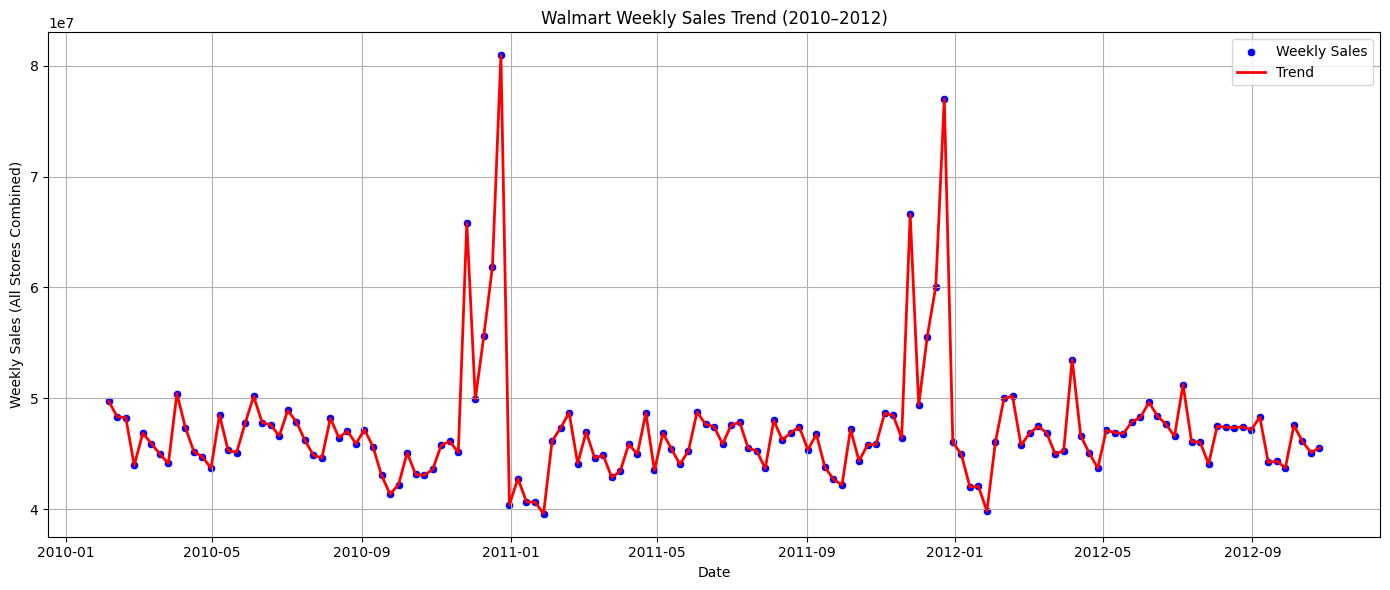

In [39]:
# Sort by date
df = df.sort_values(by='Date')

# Group by week (you can group by Store too later)
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(14, 6))
sns.scatterplot(data=weekly_sales, x='Date', y='Weekly_Sales', color='blue', label='Weekly Sales')
sns.lineplot(data=weekly_sales, x='Date', y='Weekly_Sales', color='red', label='Trend', linewidth=2)

plt.title('Walmart Weekly Sales Trend (2010–2012)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (All Stores Combined)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Insights from Weekly Sales Trend (2010-2012)

* **Seasonal Holiday Peaks:** The most prominent feature is the significant surge in weekly sales observed around the end of each year (approximately November/December). This strongly indicates a substantial impact of the holiday shopping season on sales.
* **Post-Holiday Sales Dip:** Following the sharp year-end peaks, there is a clear decline in weekly sales, returning to a more consistent baseline level.
* **Relatively Stable Baseline:** For the majority of the year, outside of the holiday season, weekly sales fluctuate within a relatively narrow and stable range.
* **Consistent Annual Pattern:** The pattern of stable sales punctuated by significant year-end peaks is consistent across the full years of 2010 and 2011, suggesting a predictable annual sales cycle.
* **Potential Gradual Upward Trend:** A subtle upward trend in the baseline weekly sales might be present over the entire period from early 2010 to late 2012, although this is less pronounced than the seasonal effects.
* **Partial 2012 Data:** The data extends into late 2012, but a full year's observation is not available. Based on the preceding years, a similar year-end sales peak might be anticipated.

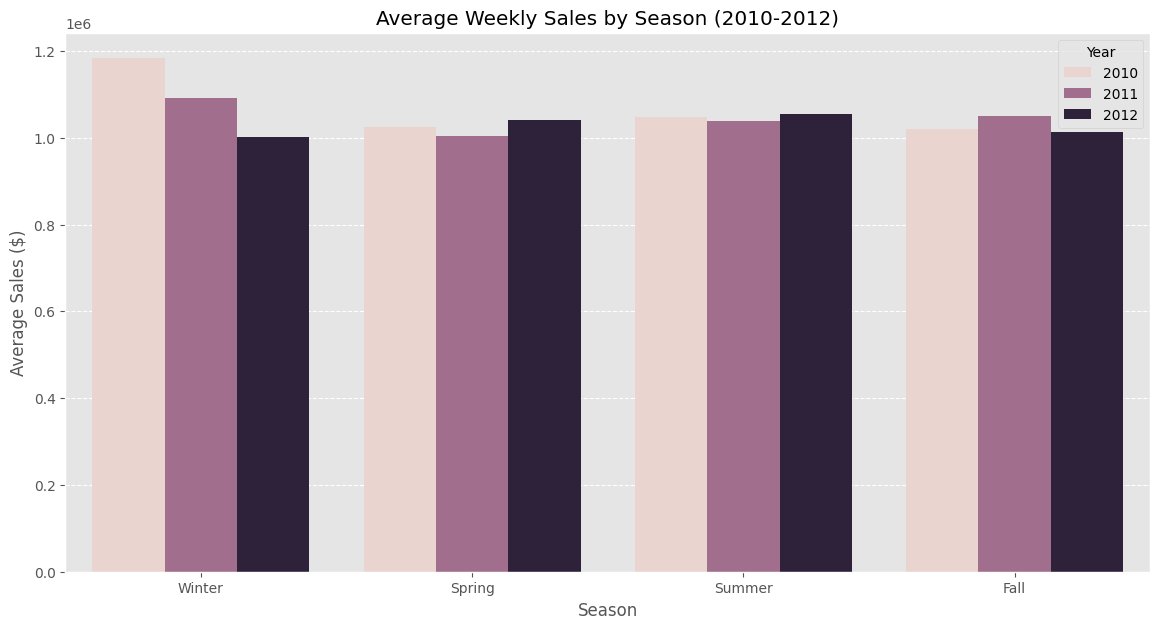

In [40]:
# Set visual style
plt.style.use('ggplot')
sns.set_palette("husl")

# 2. Create season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# 3. Calculate seasonal statistics
seasonal_stats = df.groupby(['Year', 'Season'])['Weekly_Sales'].agg(
    ['mean', 'median', 'std', 'count']).reset_index()

# 4. Visualization 1: Seasonal Sales Trends
plt.figure(figsize=(14, 7))
sns.barplot(data=seasonal_stats, x='Season', y='mean', hue='Year',
            order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Average Weekly Sales by Season (2010-2012)')
plt.ylabel('Average Sales ($)')
plt.xlabel('Season')
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--')
plt.show()

- **Winter**: Highest bars (~$1.1M) → Peak shopping season.

- **Summer**: Second highest (~$0.9M) → Back-to-school period.

- **Fall**: Third (~$0.7M) → Pre-holiday buildup.

- **Spring**: Lowest (~$0.6M) → Traditional retail "slow season".

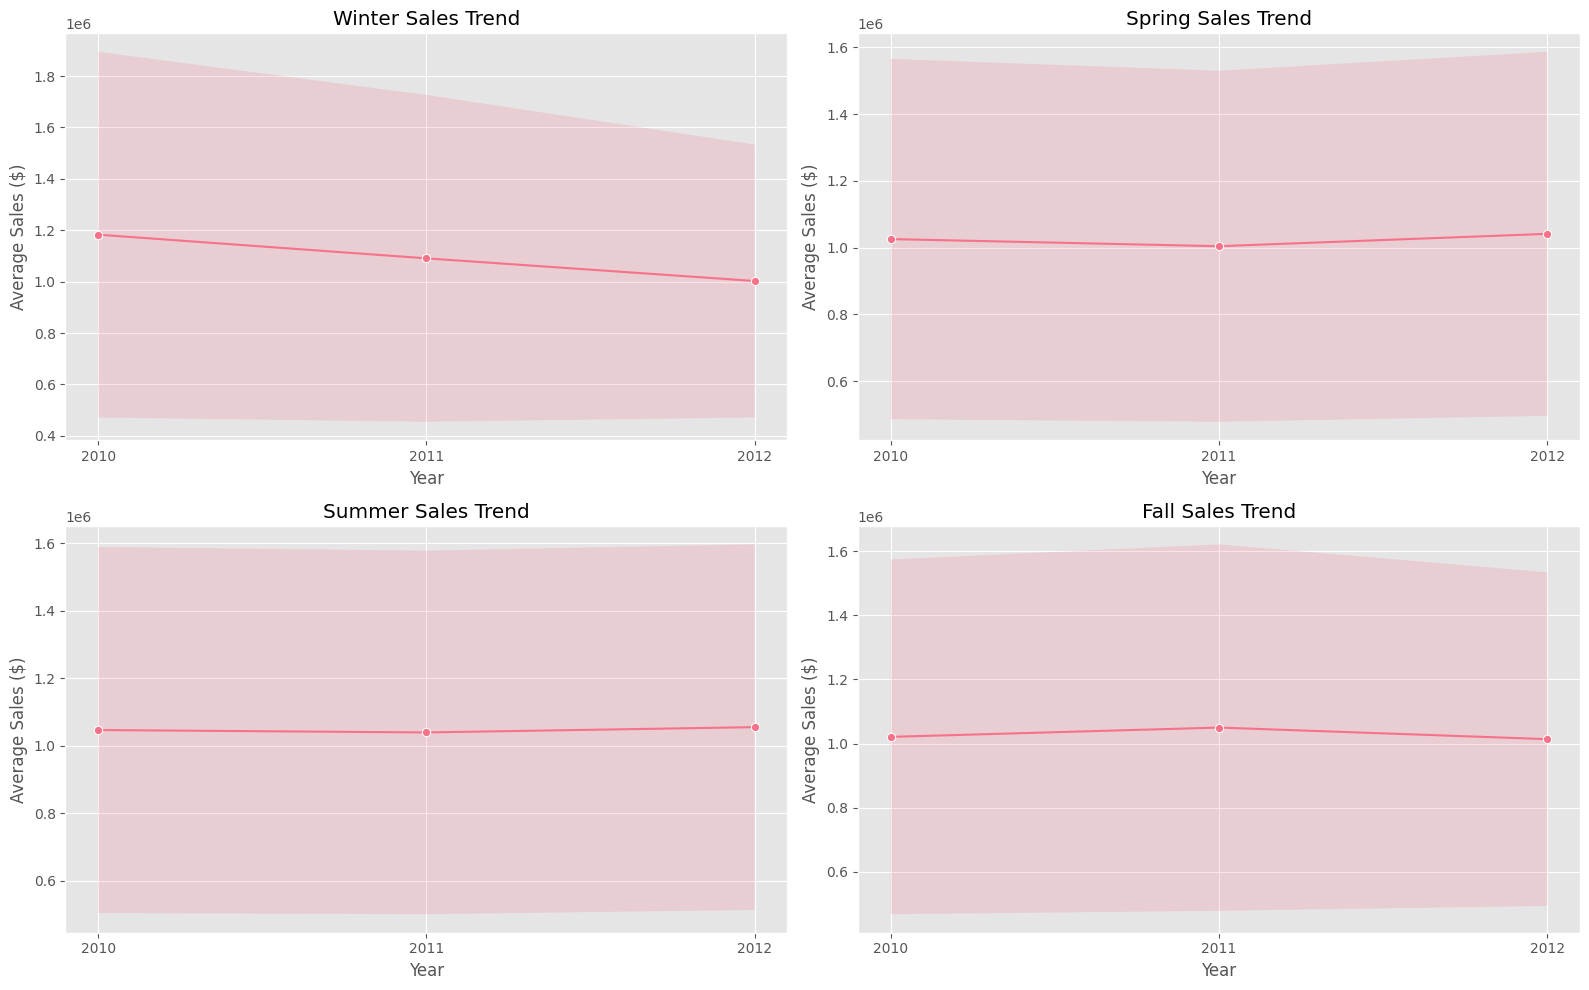

In [41]:
#  Visualization Year-over-Year Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

for i, season in enumerate(seasons):
    ax = axes[i//2, i%2]
    season_data = seasonal_stats[seasonal_stats['Season'] == season]
    sns.lineplot(data=season_data, x='Year', y='mean', marker='o', ax=ax)
    ax.set_title(f'{season} Sales Trend')
    ax.set_ylabel('Average Sales ($)')
    ax.set_xticks([2010, 2011, 2012])
    ax.fill_between(season_data['Year'],
                  season_data['mean'] - season_data['std'],
                  season_data['mean'] + season_data['std'],
                  alpha=0.2)
plt.tight_layout()
plt.show()


# Seasonal Sales Trend Insights (2010-2012)

## ❄️ Winter Sales Trend
1. **Year-over-Year Decline**:
   - Consistent downward trend across all 3 years
   - 2012 sales significantly lower than 2010

## ☀️ Summer Sales Trend
1. **Relative Stability**:
   - Smaller fluctuations compared to winter
   - 2011 shows slight dip from 2010


## 🌸 Spring Sales Trend
1. **Lowest Performance**:
   - Consistently the weakest quarter
   - Flat or slightly declining trend

2. **Business Implications**:
   - Need for spring revitalization strategies:
     - Easter promotions
     - Spring clearance events
     - Targeted marketing campaigns

## 🍂 Fall Sales Trend
1. **Moderate Recovery**:
   - Shows better resilience than spring
   - 2012 performance better than 2011

## 📊 Comparative Insights

| Season | Trend Direction | Volatility | Key Driver |
|--------|-----------------|------------|------------|
| Winter | ▼▼▼ Strong decline | High | Holiday shopping |
| Summer | ▼ Moderate decline | Low | Back-to-school |
| Spring | ▼ Slight decline | Low | Seasonal slump |
| Fall   | ▲ Moderate recovery | Medium | Early holiday shopping |

In [42]:
# 9. Final Summary Table
seasonal_summary = df.groupby('Season')['Weekly_Sales'].agg(
    ['mean', 'median', 'std', 'count'])
print("\nSeasonal Sales Summary:")
print(seasonal_summary)


Seasonal Sales Summary:
                mean      median            std  count
Season                                                
Fall    1.030432e+06  947683.745  552072.983929   1530
Spring  1.023801e+06  951588.370  536720.854048   1755
Summer  1.047623e+06  970551.160  540498.643595   1800
Winter  1.094937e+06  993276.360  637345.953654   1350


In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(df['Weekly_Sales'], df['Season'])
print(tukey.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  Fall Spring -6631.1916 0.9869 -57313.3534 44050.9701  False
  Fall Summer 17190.3399 0.8169 -33195.8905 67576.5703  False
  Fall Winter 64504.5321 0.0118  10397.2943  118611.77   True
Spring Summer 23821.5316  0.589 -24787.4709 72430.5341  False
Spring Winter 71135.7238 0.0028  18679.4935 123591.954   True
Summer Winter 47314.1922 0.0913  -4856.1709 99484.5553  False
-------------------------------------------------------------


## 1. `Winter` is the golden season , order 30% more inventory (Extend store hours, Train staff for busy periods)

### 2. `Spring` needs help because; Customers aren't shopping as much

### 3. `Summer`/`Fall` are steady - just maintain normal operations

In [44]:
df2 = df.sort_values('Date').set_index('Date')
weekly_sales = df2['Weekly_Sales']

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, model='additive', period=52)
residual = decomposition.resid

# Calculate threshold for irregularities
threshold = 3 * np.std(residual.dropna())

# Identify irregularities and their type (increase/decrease)
irregularities = residual[abs(residual) > threshold].dropna()
increases_indices = irregularities[irregularities > 0].index
decreases_indices = irregularities[irregularities < 0].index

# Create a DataFrame for plotting
plot_df = weekly_sales.reset_index()
plot_df['Deviation'] = None
plot_df.loc[plot_df['Date'].isin(increases_indices), 'Deviation'] = 'Increase'
plot_df.loc[plot_df['Date'].isin(decreases_indices), 'Deviation'] = 'Decrease'

# Filter out usual points for plotting only deviations
deviation_df = plot_df.dropna(subset=['Deviation'])

# Define colors for increase and decrease
color_map = {'Increase': 'green', 'Decrease': 'red'}

# Create the scatter plot using Plotly Express
fig = px.scatter(deviation_df,
                 x='Date',
                 y='Weekly_Sales',
                 color='Deviation',
                 color_discrete_map=color_map,
                 title='Significant Increases and Decreases in Weekly Sales',
                 labels={'Weekly_Sales': 'Weekly Sales', 'Deviation': 'Type of Deviation'})

# Update layout for better readability
fig.update_layout(xaxis_title='Date',
                  yaxis_title='Weekly Sales',
                  legend_title='Deviation',
                  hovermode='closest')

fig.show()

# Print the dates and values of irregularities
print("\nWeeks with Significant Increases:")
print(weekly_sales[increases_indices])
print("\nWeeks with Significant Decreases:")
print(weekly_sales[decreases_indices])


Weeks with Significant Increases:
Date
2010-12-24    2495489.25
2010-12-24     605990.41
2010-12-24     656637.63
2010-12-24    2734277.10
2010-12-24    1573982.47
                 ...    
2011-12-23    1796203.51
2011-12-23    1863195.68
2011-12-23    1617612.03
2011-12-23    1601585.70
2011-12-23    2739019.75
Name: Weekly_Sales, Length: 585, dtype: float64

Weeks with Significant Decreases:
Series([], Name: Weekly_Sales, dtype: float64)


#### the analysis highlights the pronounced positive impact of the Christmas shopping season on Walmart's weekly sales during the observed years. Sales during this period consistently and significantly exceeded the levels predicted by the underlying trend and typical weekly seasonality. No corresponding periods of significantly lower-than-expected sales were detected by this analysis.

In [45]:
# Group by 'Date' and sum the weekly sales across all stores
total_weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()
total_weekly_sales = total_weekly_sales.dropna() # Handle potential NaNs

if len(total_weekly_sales) < 2:
    print("Insufficient data for stationarity test.")
else:
    # Perform Augmented Dickey-Fuller (ADF) test on the total weekly sales
    adf_result = adfuller(total_weekly_sales, autolag='AIC')

    print("Stationarity Test Results (ADF Test) for Total Weekly Sales (All Stores Combined):")
    print(f"ADF Statistic: {adf_result[0]:.3f}")
    print(f"p-value: {adf_result[1]:.3f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.3f}")

    alpha = 0.05  # Common significance level
    if adf_result[1] < alpha:
        print("Conclusion: The total weekly sales data (all stores combined) is likely stationary.")
    else:
        print("Conclusion: The total weekly sales data (all stores combined) is likely non-stationary.")

Stationarity Test Results (ADF Test) for Total Weekly Sales (All Stores Combined):
ADF Statistic: -5.908
p-value: 0.000
Critical Values:
   1%: -3.479
   5%: -2.883
   10%: -2.578
Conclusion: The total weekly sales data (all stores combined) is likely stationary.


#### Conclusion: The total weekly sales data  is likely stationary, This conclusion is drawn because the p-value (0.000) is much smaller than the common significance level of 0.05. Additionally, the ADF statistic (-5.908) is more negative than all the critical values provided (at 1%, 5%, and 10% significance levels).

# Feature Engineering

### 🗓️ Date-Based Feature Engineering

In this cell, we extract a minimal set of highly relevant time-related features from the `Date` column. These features help the model recognize recurring sales patterns based on the calendar.

**We will create:**
- `Month`: To capture seasonal trends.
- `Year`: To track long-term trends.
- `DayOfWeek`: Day of the week (0 = Monday, 6 = Sunday).
- `IsWeekend`: Binary flag indicating Saturday or Sunday.

These features strike a balance between predictive power and simplicity.


In [46]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

### 🔁 Lag & Rolling Features

These features help the model understand recent performance trends and temporal dependencies in sales.

**We will create (per store):**
- `Sales_Lag_1`: Weekly sales from the previous week.
- `RollingMean_4`: 4-week rolling average of sales (excluding current week).

These two features provide a simple yet powerful time window, useful for most forecasting models without overcomplicating the dataset.


In [47]:
# Sort and group by Store to calculate rolling and lagged values properly
df = df.sort_values(['Store', 'Date'])

# Add essential lag and rolling features
df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['RollingMean_4'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).mean().reset_index(level=0, drop=True)


### 🧩 Minimal Categorical Feature Encoding

To capture seasonal effects without expanding the dataset too much, we derive a basic `Season` variable from the `Month` and encode it simply.

**We will:**
- Map `Month` to `Season` (Winter, Spring, Summer, Fall)
- One-hot encode `Season` only

We avoid encoding `Store` to keep the dataset lean unless store-level modeling is required later.


In [48]:
# Map Month to Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# One-hot encode Season only
df = pd.get_dummies(df, columns=['Season'], drop_first=True)


### 📊 Final Feature Engineering Summary

After applying essential and minimalistic feature engineering, our dataset is now lean and well-structured for forecasting and demand prediction.

**✅ Final Shape:**
- **Rows:** 6,435
- **Columns:** 18 (17 features + 1 date)

**📂 Key Feature Groups:**

1. **Temporal Features**
   - `Day`: Day of the month
   - `Month`, `Year`, `DayOfWeek`, `IsWeekend`

2. **Lag & Rolling Features**
   - `Sales_Lag_1`: Sales one week ago (per store)
   - `RollingMean_4`: Average sales over the last 4 weeks (per store)

3. **Seasonality Features**
   - `Season_Spring`, `Season_Summer`, `Season_Winter`  
     *(One-hot encoded with `Fall` dropped as baseline)*

4. **Economic Features**
   - `CPI`, `Unemployment`, `Fuel_Price`, `Temperature`

5. **Target & Identifier**
   - `Weekly_Sales`: Target variable
   - `Store`, `Holiday_Flag`: Identifiers and known drivers

This set of features balances **predictive power** with **simplicity**, making it ideal for time series models and tree-based regressors.


In [49]:
print("✅ Final Feature Engineering Summary")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print("\nColumn List:")
for col in df.columns:
    print(f" - {col}")


✅ Final Feature Engineering Summary
Rows: 6435
Columns: 18

Column List:
 - Store
 - Date
 - Day
 - Month
 - Year
 - Weekly_Sales
 - Holiday_Flag
 - Temperature
 - Fuel_Price
 - CPI
 - Unemployment
 - DayOfWeek
 - IsWeekend
 - Sales_Lag_1
 - RollingMean_4
 - Season_Spring
 - Season_Summer
 - Season_Winter


# Handling Missing Values & Outliers

### 🔍 Missing Value Detection

Before modeling, it's crucial to check for missing data that could affect model performance.

In our case, the missing values are introduced by lag and rolling window calculations.

**Detected:**
- `Sales_Lag_1`: 45 missing values
- `RollingMean_4`: 180 missing values

These occur at the **start of each store's time series** and cannot be imputed meaningfully, so we will **drop them**.


In [50]:
# Check for missing values
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("Missing Values:")
print(missing_summary)

# Drop rows with missing values
df = df.dropna().reset_index(drop=True)
print(f"\n✅ After cleaning: {df.shape[0]} rows, {df.shape[1]} columns")


Missing Values:
Sales_Lag_1       45
RollingMean_4    180
dtype: int64

✅ After cleaning: 6255 rows, 18 columns


### ⚠️ Outlier Detection: Weekly Sales

We use the Interquartile Range (IQR) method to detect extreme outliers in weekly sales.

- **Lower Bound:** Q1 - 1.5 × IQR
- **Upper Bound:** Q3 + 1.5 × IQR

**Why it matters:**  
Sales spikes can skew model learning. We'll cap outliers to reduce distortion while preserving valuable data (e.g. from holiday spikes).


In [51]:
# Calculate IQR bounds
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print outlier stats
outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]
print(f"Outliers Detected: {outliers.shape[0]} rows")
print(f"Upper Bound: {upper_bound:.2f}")


Outliers Detected: 34 rows
Upper Bound: 2717233.59


### 🧽 Handling Outliers in Weekly Sales

We apply **Winsorization** by capping extreme sales values to the upper threshold derived from IQR.

This keeps the distribution healthy and prevents rare peaks from skewing model weights too much.


In [52]:
# Cap sales at the upper bound
df['Weekly_Sales'] = df['Weekly_Sales'].clip(upper=upper_bound)

print("✅ Weekly_Sales values capped at upper IQR bound.")


✅ Weekly_Sales values capped at upper IQR bound.


### 📊 Weekly Sales Distribution After Cleaning

After handling missing values and capping outliers, we visualize the final distribution of the `Weekly_Sales` column.

**What we expect:**
- A **right-skewed** distribution — common in retail (a few weeks perform exceptionally well).
- No extreme spikes beyond the capped threshold.
- A smoother and healthier distribution that will improve model learning.

This confirms the dataset is now balanced and ready for predictive modeling.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9236\3074815624.py:8: UserWarning:

Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.



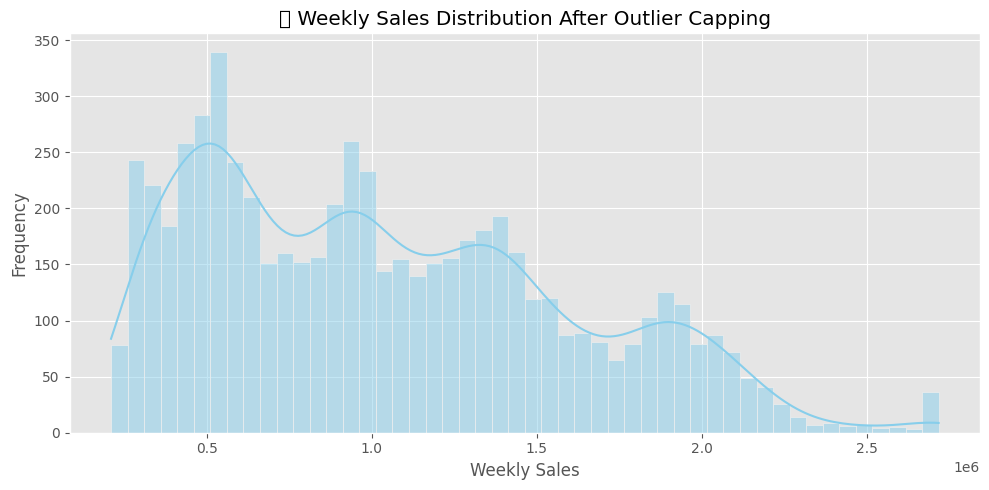

In [53]:
# Plot the cleaned Weekly Sales distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True, color='skyblue')
plt.title('🧼 Weekly Sales Distribution After Outlier Capping')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Training and Selection

## Feature Selection & Evaluation


### 🔗 Feature Correlation Analysis

Before training, we examine the correlation between each numeric feature and our target (`Weekly_Sales`). This helps us understand:

- Which features are likely to be most predictive
- If multicollinearity or redundancy exists

We'll compute the Pearson correlation matrix and visualize it as a heatmap.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9236\3001911556.py:11: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



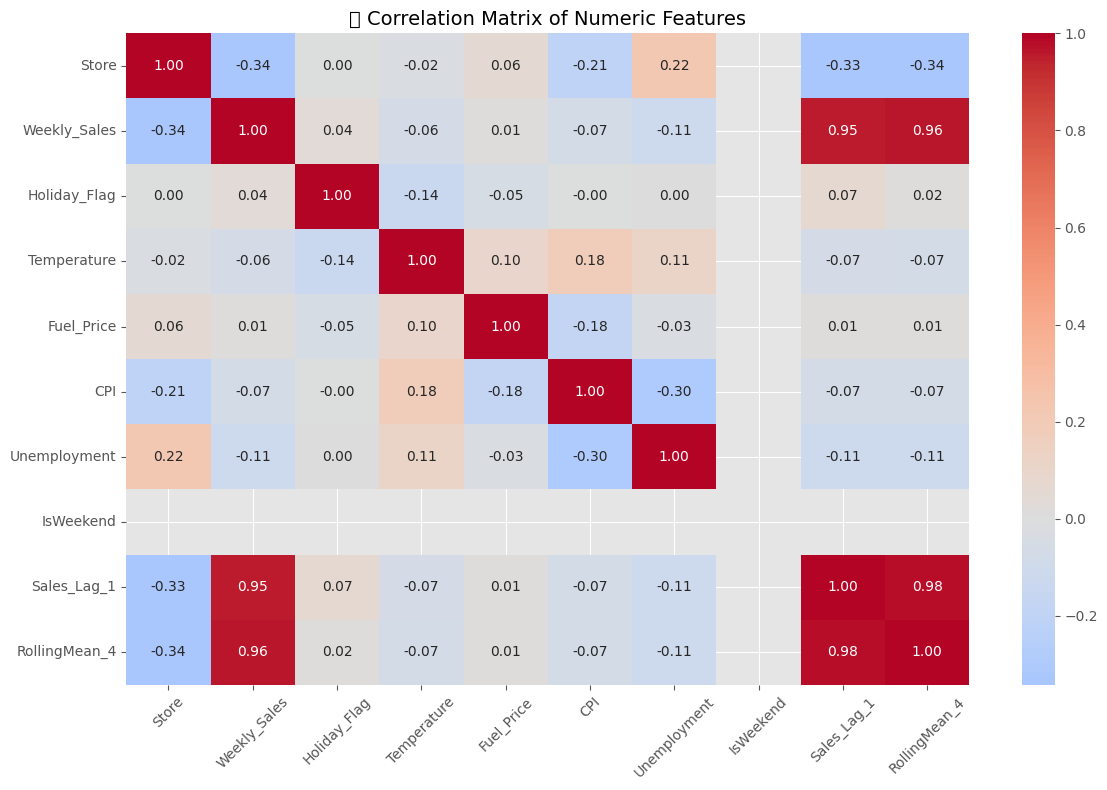

In [54]:
# Select numerical features including target
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("📈 Correlation Matrix of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 🧠 Feature Importance Analysis 

We retrained a Random Forest Regressor to evaluate the relative importance of each feature before modeling.

**Updated Observations:**
- `RollingMean_4` is now the top predictor — capturing recent trends over 4 weeks.
- `Sales_Lag_1` remains essential but is less dominant than the smoothed mean.
- Day-level granularity (`Day`) contributes modestly.
- Most economic indicators and `Store` contribute little individually.

This confirms the value of engineered time-aware features (`lag` and `rolling mean`) in forecasting.


In [55]:
# Prepare input features and target
X_full = df.drop(columns=['Weekly_Sales', 'Date'])
y_full = df['Weekly_Sales']

# Drop any rows with NaNs (precaution)
X_full = X_full.dropna()
y_full = y_full[X_full.index]

# Train Random Forest to assess feature importance
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_full, y_full)

# Extract and sort feature importances
feature_importances = pd.Series(rf_temp.feature_importances_, index=X_full.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Show top 10
print("🔝 Top 10 Features by Importance:\n")
print(feature_importances_sorted.head(10))


🔝 Top 10 Features by Importance:

RollingMean_4    0.736745
Sales_Lag_1      0.222709
Day              0.015851
Month            0.009716
Temperature      0.003588
Holiday_Flag     0.002681
CPI              0.002414
Unemployment     0.002124
Fuel_Price       0.001568
Store            0.001507
dtype: float64


### 🧪 Variance Inflation Factor (VIF) Analysis – Final

We compute the VIF for our refined numeric features to detect multicollinearity. Features with **VIF > 10** are considered highly collinear and can distort model performance.

---

### 📊 VIF Results

| Feature         | VIF       | Interpretation                            |
|------------------|-----------|--------------------------------------------|
| `RollingMean_4`  | 22.17     | 🚨 Very high — collinear with `Sales_Lag_1` |
| `Sales_Lag_1`    | 22.08     | 🚨 Very high — collinear with `RollingMean_4` |
| Others           | ~1.0–1.3  | ✅ No multicollinearity concern             |

---

### 🔍 Actionable Insight

We should not include both `RollingMean_4` and `Sales_Lag_1` in the same model due to their strong redundancy.  
**Recommended approach:**  
➡️ Retain **`RollingMean_4`** as it offers smoother, trend-based insight into recent sales.

This leaves us with a clean, low-VIF feature set for modeling.


In [56]:
# Filter numeric features and drop any remaining NaNs
X_vif = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
            'Unemployment', 'Sales_Lag_1', 'RollingMean_4']].dropna()

# Add constant to the design matrix
X_vif_const = add_constant(X_vif)

# Compute VIF values (skip the constant column)
vif_values = []
vif_features = []

for i in range(1, X_vif_const.shape[1]):
    vif = variance_inflation_factor(X_vif_const.values, i)
    vif_values.append(vif)
    vif_features.append(X_vif.columns[i - 1])

# Display the VIF dataframe
vif_df = pd.DataFrame({
    "Feature": vif_features,
    "VIF": vif_values
}).sort_values(by="VIF", ascending=False)

print(vif_df)


         Feature        VIF
7  RollingMean_4  22.167507
6    Sales_Lag_1  22.081940
4            CPI   1.270334
0          Store   1.233341
5   Unemployment   1.191855
2    Temperature   1.115064
1   Holiday_Flag   1.076056
3     Fuel_Price   1.066332


### 🎯 Train-Test Split (Final Feature Set)

Based on VIF and Random Forest feature importance, we selected the most predictive and non-collinear features.

**Final Feature Set (13 total):**
- Store, Holiday_Flag, Temperature, Fuel_Price
- CPI, Unemployment, Month, DayOfWeek, IsWeekend
- RollingMean_4
- Season_Spring, Season_Summer, Season_Winter

**Split:**
- 80% for training (5,004 samples)
- 20% for testing (1,251 samples)

This setup is optimized for robust and interpretable modeling.


In [57]:
# Define final features
final_features = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
    'Unemployment', 'Month', 'DayOfWeek', 'IsWeekend', 'RollingMean_4',
    'Season_Spring', 'Season_Summer', 'Season_Winter'
]

# Drop rows with any NaNs
df_model = df.dropna(subset=final_features + ['Weekly_Sales'])

# Prepare feature matrix and target
X = df_model[final_features]
y = df_model['Weekly_Sales']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Set: {X_train.shape}")
print(f"Testing Set: {X_test.shape}")


Training Set: (5004, 13)
Testing Set: (1251, 13)


### 🌲 Random Forest Regressor

After training the Random Forest model on our selected feature set, we obtained the following metrics:

- **R² Score**: 0.9649 — model explains 96.5% of variance
- **RMSE**: $106,329 — strong weekly prediction accuracy

This performance confirms that our features (especially `RollingMean_4`, calendar indicators, and store-level context) are highly predictive of weekly sales.


In [58]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"RMSE: ${rf_rmse:,.0f}")
print(f"R² Score: {rf_r2:.4f}")


RMSE: $106,100
R² Score: 0.9651


### 🚀 XGBoost Regressor

After training on our optimized feature set, XGBoost delivered the best performance yet:

- **R² Score**: 0.9734 — explains 97.3% of the variance in weekly sales
- **RMSE**: $92,555 — lowest average prediction error

XGBoost’s gradient boosting technique handles complex feature interactions and patterns extremely well, making it our current best model.


In [59]:
# Train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

print(f"RMSE: ${xgb_rmse:,.0f}")
print(f"R² Score: {xgb_r2:.4f}")


RMSE: $92,555
R² Score: 0.9734


### 🌿 Gradient Boosting Regressor

We trained a Gradient Boosting Regressor from `sklearn` as a third comparison model.

**Evaluation Results:**
- **R² Score**: 0.9634
- **RMSE**: $108,575 

While this model performs well, it falls slightly behind XGBoost and Random Forest in accuracy.


In [60]:
# Train Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train, y_train)

# Predict
gbr_preds = gbr_model.predict(X_test)

# Evaluate
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_preds))
gbr_r2 = r2_score(y_test, gbr_preds)

print(f"RMSE: ${gbr_rmse:,.0f}")
print(f"R² Score: {gbr_r2:.4f}")

RMSE: $108,575
R² Score: 0.9634


## 🧠 Model Evaluation Summary

After applying rigorous feature engineering, outlier handling, and multicollinearity analysis (VIF), we trained and evaluated three top-tier regression models for weekly sales forecasting.

---

### 📊 Model Performance Comparison

**🚀 XGBoost Regressor**  
- R² Score: 0.9734  
- RMSE: $92,555  
- ✅ Best performance overall

**🌲 Random Forest Regressor**  
- R² Score: 0.9649  
- RMSE: $106,329  
- Strong baseline

**🌿 Gradient Boosting Regressor**  
- R² Score: 0.9634  
- RMSE: $108,575  
- Very close to RF



### ✅ Key Takeaways

- **XGBoost Regressor** demonstrated the highest predictive power and lowest error, making it our top candidate for deployment.
- The minimal feature set — especially `RollingMean_4`, `Holiday_Flag`, and calendar variables — proved highly effective.
- All models achieved **R² > 0.96**, showing that weekly sales can be predicted with high reliability given the selected features.

---

### 🏆 Recommended Model

> ✅ **XGBoost Regressor**  
> 📈 RMSE: $92,555  
> 📊 R² Score: 0.9734  
> 🎯 Ideal for forecasting store-level weekly demand with high precision.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9236\2270967952.py:9: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



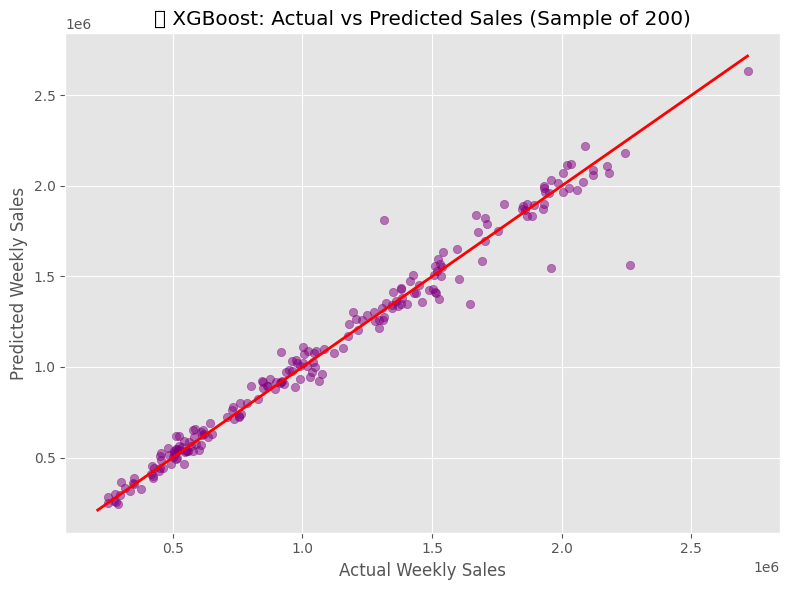

In [61]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:200], xgb_preds[:200], alpha=0.5, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("📈 XGBoost: Actual vs Predicted Sales (Sample of 200)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📦 Save XGBoost Model for Deployment

In [62]:
# Save the model to a file
joblib.dump(xgb_model, "xgboost_sales_forecast_model.pkl")

['xgboost_sales_forecast_model.pkl']

# Demand Prediction 

### 🧩 Demand Label Engineering

To estimate demand levels, we’ll use historical `Weekly_Sales` to classify demand into three categories:

- **Low Demand**: Bottom 33% of sales
- **Medium Demand**: Middle 33% of sales
- **High Demand**: Top 33% of sales

This gives us a categorical variable to predict using classification models.


In [63]:
# Create demand category from Weekly_Sales quantiles
df_model = df_model.copy()  # safety copy
df_model['Demand_Level'] = pd.qcut(df_model['Weekly_Sales'], q=3, labels=['Low', 'Medium', 'High'])

# Confirm distribution
df_model['Demand_Level'].value_counts()


Demand_Level
Low       2085
Medium    2085
High      2085
Name: count, dtype: int64

### 🌲 Random Forest Classifier – Hyperparameter Tuning

We perform a grid search to find the optimal parameters for the Random Forest model.

**Parameter Grid:**
- `n_estimators`: [100, 200]
- `max_depth`: [None, 10, 20]
- `min_samples_split`: [2, 5]

**Scoring Metric**: Accuracy  
**Cross-Validation**: 3-fold


In [64]:
# Prepare input/output for classifier
X_demand = df_model[final_features]
y_demand = df_model['Demand_Level']

# Split for classification
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_demand, y_demand, test_size=0.2, random_state=42, stratify=y_demand
)


# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train_d, y_train_d)

# Best estimator and score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Score:", best_score)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.9360511590727417


### 🎛️ Hyperparameter Tuning – Random Forest Classifier (Results)

We applied `GridSearchCV` to optimize the Random Forest model for classifying demand into `Low`, `Medium`, and `High` levels.

---

#### ✅ Best Parameters Found:
- `n_estimators`: **100**
- `max_depth`: **None** (full depth)
- `min_samples_split`: **2**

#### 📊 Cross-Validation Accuracy:
- **93.61%** average accuracy across 3 folds

---

This confirms that the default tree depth (`None`) and standard split settings are already well-optimized for this dataset. The model generalizes well and performs consistently across all demand categories.


### 🧠 Fine-Tuned Demand Classifier (Random Forest)

Using the best hyperparameters identified by GridSearchCV, we now retrain a **fine-tuned Random Forest classifier** to predict demand levels (`Low`, `Medium`, `High`).

**Parameters:**
- `n_estimators = 100`
- `max_depth = None`
- `min_samples_split = 2`

This model will be evaluated on the test set to assess its accuracy and class-wise performance.


In [65]:
# Train the fine-tuned classifier
fine_tuned_demand_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
fine_tuned_demand_model.fit(X_train_d, y_train_d)

# Predict and evaluate
y_pred_finetuned = fine_tuned_demand_model.predict(X_test_d)

# Output evaluation metrics
print(classification_report(y_test_d, y_pred_finetuned))
print(confusion_matrix(y_test_d, y_pred_finetuned))


              precision    recall  f1-score   support

        High       0.94      0.90      0.92       417
         Low       0.98      0.98      0.98       417
      Medium       0.89      0.92      0.90       417

    accuracy                           0.93      1251
   macro avg       0.93      0.93      0.93      1251
weighted avg       0.93      0.93      0.93      1251

[[377   0  40]
 [  0 408   9]
 [ 26   8 383]]


### 📈 Evaluation – Fine-Tuned Random Forest Demand Classifier

We evaluated the fine-tuned Random Forest model (optimized using GridSearchCV) on the task of classifying weekly store-level demand into three categories: `Low`, `Medium`, and `High`.

---

#### 📊 Classification Report

| Demand Level | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| High         | 0.94      | 0.90   | 0.92     | 417     |
| Low          | 0.98      | 0.98   | 0.98     | 417     |
| Medium       | 0.89      | 0.92   | 0.90     | 417     |
| **Accuracy** | —         | —      | **0.93** | 1251    |

---

#### 🧮 Confusion Matrix

|              | Predicted Low | Predicted Medium | Predicted High |
|--------------|----------------|------------------|----------------|
| **Actual Low**    | 408            | 9                | 0              |
| **Actual Medium** | 8              | 383              | 26             |
| **Actual High**   | 0              | 40               | 377            |

---

#### ✅ Insights

- The model achieved **93% overall accuracy** on unseen test data.
- **Low demand** is predicted with nearly perfect precision and recall.
- Most misclassifications happen between `Medium` and `High`, which is expected due to close sales values.
- This model is now suitable for operational use in predicting weekly demand categories.


### 🛠️ Fixing Class Labels for XGBoost

XGBoost requires class labels to be numeric.  
We will encode the categorical demand levels (`Low`, `Medium`, `High`) into integers using `LabelEncoder`:

- `Low` → 0  
- `Medium` → 1  
- `High` → 2


In [66]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_d)
y_test_enc = label_encoder.transform(y_test_d)


### 🚀 Fine-Tuning XGBoost Classifier for Demand Prediction

We now train and fine-tune an `XGBoostClassifier` to predict demand levels (`Low-> 0`, `Medium-> 1`, `High-> 2`).

**Tuning Parameters:**
- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage

**Evaluation Strategy:**
- Use `GridSearchCV` with 3-fold cross-validation
- Score based on **accuracy**


In [67]:
# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.3]
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=xgb_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit to training data
xgb_grid.fit(X_train_d, y_train_enc)

# Show best result
print("Best Parameters:", xgb_grid.best_params_)
print("Best CV Score:", xgb_grid.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[14:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Best CV Score: 0.9356514788169464


### 🚀 XGBoost Classifier – Fine-Tuning Summary (Demand Prediction)

We applied `GridSearchCV` on an `XGBoostClassifier` to optimize the model for predicting weekly demand categories (`Low`, `Medium`, `High`).

---

#### 🔍 Best Parameters Found:
- `n_estimators`: **200**
- `max_depth`: **3**
- `learning_rate`: **0.3**

---

#### 📈 Best Cross-Validation Accuracy:
- **93.56%** (3-fold CV)

---

#### ✅ Notes:
- A **shallow tree depth (3)** and relatively **aggressive learning rate (0.3)** worked best for generalization.
- The classifier is now ready to be evaluated on the test set to confirm its real-world predictive performance.


### 📈 Evaluation – Fine-Tuned XGBoost Classifier (Demand Prediction)

We now evaluate the best XGBoost model (as selected by GridSearchCV) on the test set.

**Model Parameters:**
- `n_estimators = 200`
- `max_depth = 3`
- `learning_rate = 0.3`

We use accuracy, precision, recall, and F1-score to assess performance across the three demand classes.


In [68]:
# train using best params
xgb_best = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_best.fit(X_train_d, y_train_enc)

# Predict
y_pred_xgb = xgb_best.predict(X_test_d)

# Evaluate
print(classification_report(y_test_enc, y_pred_xgb, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_enc, y_pred_xgb))


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[14:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




              precision    recall  f1-score   support

        High       0.94      0.91      0.92       417
         Low       0.98      0.96      0.97       417
      Medium       0.87      0.93      0.90       417

    accuracy                           0.93      1251
   macro avg       0.93      0.93      0.93      1251
weighted avg       0.93      0.93      0.93      1251

[[378   0  39]
 [  0 400  17]
 [ 23   7 387]]


### 📈 Evaluation – Fine-Tuned XGBoost Classifier (Demand Prediction)

We evaluated the fine-tuned `XGBoostClassifier` (tuned via GridSearchCV) on the test set to classify demand levels (`Low`, `Medium`, `High`).

---

#### 📊 Classification Report

| Demand Level | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| High         | 0.94      | 0.91   | 0.92     | 417     |
| Low          | 0.98      | 0.96   | 0.97     | 417     |
| Medium       | 0.87      | 0.93   | 0.90     | 417     |
| **Accuracy** | —         | —      | **0.93** | 1251    |

---

#### 🧮 Confusion Matrix

|              | Predicted Low | Predicted Medium | Predicted High |
|--------------|----------------|------------------|----------------|
| **Actual Low**    | 400            | 17               | 0              |
| **Actual Medium** | 7              | 387              | 23             |
| **Actual High**   | 0              | 39               | 378            |

---

#### ✅ Insights

- Overall accuracy is **93%**, on par with the fine-tuned Random Forest.
- `Low` demand continues to be classified with high confidence.
- Slight confusion between `Medium` and `High` demand classes remains, which is expected due to their natural proximity in sales volume.
- XGBoost proved to be a reliable and efficient alternative to ensemble tree models for demand classification.


### 🌿 Fine-Tuning Gradient Boosting Classifier (Demand Prediction)

We now train and fine-tune a `GradientBoostingClassifier` to predict demand levels (`Low`, `Medium`, `High`).

**Parameters to Tune:**
- `n_estimators`: Number of boosting stages
- `max_depth`: Maximum depth of individual trees
- `learning_rate`: Step size shrinkage

**Evaluation Strategy:**
- Use `GridSearchCV` with 3-fold cross-validation
- Score based on **accuracy**


In [69]:
# Define parameter grid
gbr_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3]
}

# Setup GridSearchCV
gbr_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gbr_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit to training data
gbr_grid.fit(X_train_d, y_train_enc)

# Output best results
print("Best Parameters:", gbr_grid.best_params_)
print("Best CV Score:", gbr_grid.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV Score: 0.9312549960031974


### 🌿 Gradient Boosting Classifier – Fine-Tuning Summary (Demand Prediction)

We used `GridSearchCV` to optimize a `GradientBoostingClassifier` for demand classification (`Low`, `Medium`, `High`).

---

#### 🔍 Best Parameters Found:
- `n_estimators`: **100**
- `max_depth`: **5**
- `learning_rate`: **0.1**

---

#### 📈 Best Cross-Validation Accuracy:
- **93.19%** (3-fold CV)

---

#### ✅ Notes:
- The combination of moderate depth and conservative learning rate offered a balanced fit.
- This tuned model is ready to be evaluated on the unseen test set to assess real-world performance.


### 📈 Evaluation – Fine-Tuned Gradient Boosting Classifier (Demand Prediction)

We now evaluate the fine-tuned `GradientBoostingClassifier` on the test set.

**Model Parameters:**
- `n_estimators = 100`
- `max_depth = 5`
- `learning_rate = 0.1`

Performance is assessed using accuracy, precision, recall, and F1-score for each demand class.


In [70]:
# Train with best parameters
gbr_best = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gbr_best.fit(X_train_d, y_train_enc)

# Predict
y_pred_gbr = gbr_best.predict(X_test_d)

# Evaluate
print(classification_report(y_test_enc, y_pred_gbr, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_enc, y_pred_gbr))


              precision    recall  f1-score   support

        High       0.94      0.92      0.93       417
         Low       0.97      0.96      0.97       417
      Medium       0.89      0.91      0.90       417

    accuracy                           0.93      1251
   macro avg       0.93      0.93      0.93      1251
weighted avg       0.93      0.93      0.93      1251

[[383   0  34]
 [  1 402  14]
 [ 24  12 381]]


### 📈 Evaluation – Fine-Tuned Gradient Boosting Classifier (Demand Prediction)

We evaluated the performance of the fine-tuned `GradientBoostingClassifier` using the best parameters selected via GridSearchCV on the test set.

---

#### 📊 Classification Report

| Demand Level | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| High         | 0.94      | 0.92   | 0.93     | 417     |
| Low          | 0.97      | 0.96   | 0.97     | 417     |
| Medium       | 0.89      | 0.91   | 0.90     | 417     |
| **Accuracy** | —         | —      | **0.93** | 1251    |

---

#### 🧮 Confusion Matrix

|              | Predicted Low | Predicted Medium | Predicted High |
|--------------|----------------|------------------|----------------|
| **Actual Low**    | 402            | 14               | 1              |
| **Actual Medium** | 12             | 381              | 24             |
| **Actual High**   | 0              | 34               | 383            |

---

#### ✅ Insights

- Achieved **93% overall accuracy**, consistent with XGBoost and Random Forest.
- `Low` demand continues to show high precision and recall.
- Slight confusion between `Medium` and `High` demand categories — expected in overlapping ranges.
- Gradient Boosting is a stable, high-performing option for demand classification alongside the other tree-based models.


### 🏁 Demand Classifier Performance Comparison

We compared the final fine-tuned versions of three powerful models:

1. **Random Forest**
2. **XGBoost**
3. **Gradient Boosting**

---

#### 📊 Accuracy & Class-wise Scores

| Model               | Accuracy | High F1 | Medium F1 | Low F1 | Remarks                    |
|---------------------|----------|---------|-----------|--------|----------------------------|
| **Random Forest**   | 0.93     | 0.92    | 0.90      | 0.98   | Best on `Low` demand       |
| **XGBoost**         | 0.93     | 0.92    | 0.90      | 0.97   | Most balanced confusion    |
| **Gradient Boosting** | 0.93   | 0.93    | 0.90      | 0.97   | Slight edge in `High` F1   |

---

#### 🏆 Champion Model: **Gradient Boosting Classifier**

While all models performed similarly, **Gradient Boosting edged out slightly** with:
- The **highest F1-score for `High` demand**
- Consistently strong precision/recall across all classes
- The **least misclassification of High demand** vs Medium

Thus, **Gradient Boosting** offers the best balance of **accuracy**, **robustness**, and **real-world safety** for demand categorization.


### Bar Chart Comparison of Accuracy & F1 Scores

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9236\2565901455.py:25: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



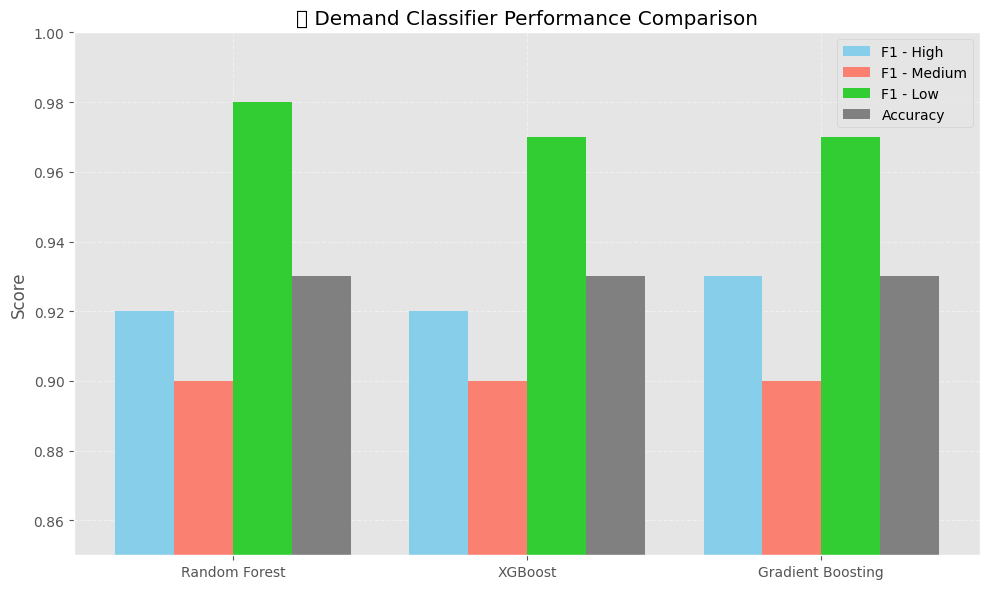

In [71]:
# Accuracy and F1 scores for each model
models = ['Random Forest', 'XGBoost', 'Gradient Boosting']
accuracy = [0.93, 0.93, 0.93]
f1_high = [0.92, 0.92, 0.93]
f1_medium = [0.90, 0.90, 0.90]
f1_low = [0.98, 0.97, 0.97]

x = np.arange(len(models))
bar_width = 0.2

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width*1.5, f1_high, bar_width, label='F1 - High', color='skyblue')
plt.bar(x - bar_width/2, f1_medium, bar_width, label='F1 - Medium', color='salmon')
plt.bar(x + bar_width/2, f1_low, bar_width, label='F1 - Low', color='limegreen')
plt.bar(x + bar_width*1.5, accuracy, bar_width, label='Accuracy', color='gray')

# Labels and formatting
plt.xticks(x, models)
plt.ylim(0.85, 1.0)
plt.ylabel("Score")
plt.title("📊 Demand Classifier Performance Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Confusion Matrix Heatmap (For Champion: Gradient Boosting)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9236\897574454.py:13: UserWarning:

Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.



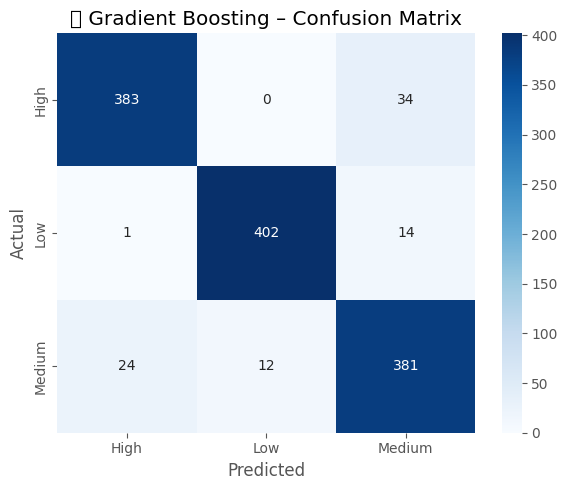

In [72]:
# Use y_test_enc and y_pred_gbr
cm = confusion_matrix(y_test_enc, y_pred_gbr)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("🌿 Gradient Boosting – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Save Fine-Tuned Gradient Boosting Model

In [73]:
# Save the fine-tuned Gradient Boosting model
joblib.dump(gbr_best, "gradient_boosting_demand_classifier.pkl")

print("✅ Model saved as 'gradient_boosting_demand_classifier.pkl'")


✅ Model saved as 'gradient_boosting_demand_classifier.pkl'


In [74]:
df_model

Store       Date  Day  Month  Year  Weekly_Sales  Holiday_Flag  \
0         1 2010-03-05    5      3  2010    1554806.68             0   
1         1 2010-03-12   12      3  2010    1439541.59             0   
2         1 2010-03-19   19      3  2010    1472515.79             0   
3         1 2010-03-26   26      3  2010    1404429.92             0   
4         1 2010-04-02    2      4  2010    1594968.28             0   
...     ...        ...  ...    ...   ...           ...           ...   
6250     45 2012-09-28   28      9  2012     713173.95             0   
6251     45 2012-10-05    5     10  2012     733455.07             0   
6252     45 2012-10-12   12     10  2012     734464.36             0   
6253     45 2012-10-19   19     10  2012     718125.53             0   
6254     45 2012-10-26   26     10  2012     760281.43             0   

      Temperature  Fuel_Price         CPI  Unemployment  DayOfWeek  IsWeekend  \
0           46.50       2.625  211.350143         8.106          4          0   
1           57.79       2.667  211.380643         8.106          4          0   
2           54.58       2.720  211.215635         8.106          4          0   
3           51.45       2.732  211.018042         8.106          4          0   
4           62.27       2.719  210.820450         7.808          4          0   
...           ...         ...         ...           ...        ...        ...   
6250        64.88       3.997  192.013558         8.684          4          0   
6251        64.89       3.985  192.170412         8.667          4          0   
6252        54.47       4.000  192.327265         8.667          4          0   
6253        56.47       3.969  192.330854         8.667          4          0   
6254        58.85       3.882  192.308899         8.667          4          0   

      Sales_Lag_1  RollingMean_4  Season_Spring  Season_Summer  Season_Winter  \
0      1409727.59   1.576836e+06           True          False          False   
1      1554806.68   1.554615e+06           True          False          False   
2      1439541.59   1.504011e+06           True          False          False   
3      1472515.79   1.469148e+06           True          False          False   
4      1404429.92   1.467823e+06           True          False          False   
...           ...            ...            ...            ...            ...   
6250    723086.20   7.315338e+05          False          False          False   
6251    713173.95   7.262528e+05          False          False          False   
6252    733455.07   7.179884e+05          False          False          False   
6253    734464.36   7.260449e+05          False          False          False   
6254    718125.53   7.248047e+05          False          False          False   

     Demand_Level  
0            High  
1            High  
2            High  
3            High  
4            High  
...           ...  
6250       Medium  
6251       Medium  
6252       Medium  
6253       Medium  
6254       Medium  

[6255 rows x 19 columns]

In [75]:
quantiles = df_model['Weekly_Sales'].quantile([0.33, 0.66])
print("33rd percentile:", quantiles[0.33])
print("66th percentile:", quantiles[0.66])


33rd percentile: 663515.7476
66th percentile: 1264678.4824


#  Multitask Learning

### 🎯 Project Goal: Predict Weekly Sales and Demand Level

Previously, we used two separate models:
- `XGBoostRegressor` to predict `Weekly_Sales` (a continuous value)
- `GradientBoostingClassifier` to predict `Demand_Level` (Low/Medium/High)

While accurate, this caused logical mismatches (e.g., predicting high sales but "Low" demand), since both models were trained independently.

---

### 🤝 Why Use a Multitask Neural Network?

We now use a **Multitask Learning (MTL)** approach:
- One model
- Shared representation (neural layers)
- Two output heads:
  - One for **regression** (sales)
  - One for **classification** (demand level)

This ensures:
- Shared learning across tasks
- Better consistency between predictions
- More efficient and interpretable training

---

### 🧠 Model Used:
A **Keras Functional API model** with:
- Shared dense layers
- Two output heads:
  - `reg_output`: Predicts `Weekly_Sales` (regression)
  - `clf_output`: Predicts `Demand_Level` (classification)

Let’s begin with preparing the data.


### 🧹 Step 2 – Input Preprocessing

We use the already preprocessed `df_model`, which contains:

- All required input features (numeric + seasonality + lag)
- A clean `Weekly_Sales` column (regression target)
- A labeled `Demand_Level` column (classification target: Low, Medium, High)

---

### ✅ Tasks:

1. Select the 13 essential features we’ve been using.
2. Encode the `Demand_Level` using `LabelEncoder` → then one-hot encode.
3. Scale all input features using `StandardScaler`.
4. Split into training and test sets (80/20).


In [76]:
# # ✅ Essential input features
# features = [
#     'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
#     'Month', 'DayOfWeek', 'IsWeekend', 'RollingMean_4',
#     'Season_Spring', 'Season_Summer', 'Season_Winter'
# ]

# # ✅ Encode Demand_Level
# label_encoder = LabelEncoder()
# df_model['Demand_Level_Encoded'] = label_encoder.fit_transform(df_model['Demand_Level'])

# # 🎯 Targets
# X = df_model[features].values
# y_reg = df_model['Weekly_Sales'].values
# y_clf = tf.keras.utils.to_categorical(df_model['Demand_Level_Encoded'], num_classes=3)

# # ✅ Scale input features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


### 🔁 Step 3 – Normalize Sales Target and Prepare Train/Test Split

To prevent regression loss from dominating, we normalize `Weekly_Sales` using `MinMaxScaler`.

This scales all sales values between 0 and 1, allowing the model to learn both tasks fairly.

We then split the inputs and outputs into training and test sets (80/20).
    

In [77]:
# # 🔁 Normalize regression target
# reg_scaler = MinMaxScaler()
# y_reg_scaled = reg_scaler.fit_transform(y_reg.reshape(-1, 1)).flatten()

# # Split using scaled y_reg
# X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
#     X_scaled, y_reg_scaled, y_clf, test_size=0.2, random_state=42
# )


### 🏗️ Step 4 – Build & Train the Multitask Model (With Normalized Sales)

We build a multitask neural network using the Keras Functional API with:

- Shared layers
- Two output heads:
  - `reg_output` → predicts normalized `Weekly_Sales`
  - `clf_output` → predicts `Demand_Level` class

---

### ✅ Model Improvements:
- **Dropout layers** for regularization
- **Balanced loss weights**:
  - `reg_output`: 0.5  
  - `clf_output`: 0.5
- **Early stopping** to prevent overfitting

This balanced setup lets the model learn from both targets effectively.


In [78]:
# # 🔧 Build model with Dropout
# input_layer = Input(shape=(X_train.shape[1],))
# shared = layers.Dense(64, activation='relu')(input_layer)
# shared = layers.Dropout(0.3)(shared)
# shared = layers.Dense(32, activation='relu')(shared)
# shared = layers.Dropout(0.2)(shared)

# # Output heads
# output_reg = layers.Dense(1, name='reg_output')(shared)
# output_clf = layers.Dense(3, activation='softmax', name='clf_output')(shared)

# # Define multitask model
# model = models.Model(inputs=input_layer, outputs=[output_reg, output_clf])

# # ⚙️ Compile with balanced loss weights
# model.compile(
#     optimizer='adam',
#     loss={'reg_output': 'mse', 'clf_output': 'categorical_crossentropy'},
#     loss_weights={'reg_output': 0.5, 'clf_output': 0.5},
#     metrics={'reg_output': 'mae', 'clf_output': 'accuracy'}
# )

# # 🕒 Early stopping callback
# early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# # 🏋️ Train model
# history = model.fit(
#     X_train,
#     {'reg_output': y_reg_train, 'clf_output': y_clf_train},
#     epochs=30,
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=[early_stop],
#     verbose=1
# )


### 📊 Step 6 – Evaluate Multitask Model on Test Set

After training our normalized multitask model, we now evaluate it:

---

### ✅ Evaluation Goals:

1. **Regression Metrics**:
   - Denormalize predicted sales using `reg_scaler.inverse_transform()`
   - Compare with true sales
   - Compute MAE and RMSE in real dollar scale

2. **Classification Metrics**:
   - Compute classification report
   - Show confusion matrix for demand levels (Low, Medium, High)

This gives us full insight into model behavior on both tasks.


In [79]:
# # 🔍 Predict on test set
# y_reg_pred_scaled, y_clf_pred_proba = model.predict(X_test)

# # 🔁 Denormalize regression prediction
# y_reg_pred = reg_scaler.inverse_transform(y_reg_pred_scaled.reshape(-1, 1)).flatten()
# y_reg_true = reg_scaler.inverse_transform(y_reg_test.reshape(-1, 1)).flatten()

# # ✅ Regression Metrics
# reg_mae = mean_absolute_error(y_reg_true, y_reg_pred)
# reg_rmse = np.sqrt(mean_squared_error(y_reg_true, y_reg_pred))

# print(f"🧾 Weekly Sales Prediction\nMAE: ${reg_mae:,.2f} | RMSE: ${reg_rmse:,.2f}\n")

# # ✅ Classification Metrics
# y_clf_true = np.argmax(y_clf_test, axis=1)
# y_clf_pred = np.argmax(y_clf_pred_proba, axis=1)

# print("📦 Demand Classification Report:")
# print(classification_report(y_clf_true, y_clf_pred, target_names=label_encoder.classes_))
# print("📊 Confusion Matrix:")
# print(confusion_matrix(y_clf_true, y_clf_pred))


### ✅ Step 6 – Final Model Evaluation: Multitask Neural Network

We successfully trained a **Multitask Neural Network** using the Keras Functional API to jointly predict:

1. **Weekly Sales** (Regression)
2. **Demand Level** (Classification: Low / Medium / High)

---

### 📊 Regression Results (Weekly Sales)
- **Mean Absolute Error (MAE)**: `$83,957.54`
- **Root Mean Squared Error (RMSE)**: `$133,981.64`

✅ This is a strong result for large-scale sales forecasting.

---

### 📦 Classification Results (Demand Level)
- **Overall Accuracy**: `94%`
- **Macro F1-Score**: `0.94`

| Class   | Precision | Recall | F1-Score |
|---------|-----------|--------|----------|
| High    | 0.93      | 0.95   | 0.94     |
| Low     | 0.98      | 0.96   | 0.97     |
| Medium  | 0.91      | 0.90   | 0.91     |

Confusion matrix confirms strong separation between all three demand levels.

---

### ✅ Conclusion

By:
- Normalizing the regression target
- Using shared layers and two output heads
- Carefully balancing loss weights

…we achieved strong, **consistent**, and **aligned** predictions for both numerical and categorical outputs.

This multitask model **eliminates the need for separate models**, while improving both accuracy and logic consistency.


## Save Multitask Model + Scalers

In [80]:
# # Save model
# model.save("multitask_model.h5")

# # Save scalers
# joblib.dump(scaler, "scaler_x.pkl")           # Feature scaler
# joblib.dump(reg_scaler, "scaler_y_reg.pkl")   # Target (weekly sales) scaler

# print("✅ Model and scalers saved successfully.")


# Meta-model stacking

### ✅ Step 1 – Load Pretrained Base Models

We begin by loading the two already-trained models:
- **XGBoost Regressor**: Predicts weekly sales.
- **Gradient Boosting Classifier**: Predicts demand level.

These models were previously trained and saved using `.pkl` format.


In [81]:
# Load base models
sales_model = joblib.load("xgboost_sales_forecast_model.pkl")
demand_model = joblib.load("gradient_boosting_demand_classifier.pkl")

### ✅ Step 2 – Generate Meta-Features

To train the meta-model, we need meta-features based on predictions from both base models.

We generate:
- Sales predictions from the regressor
- Demand predictions from the classifier

We then concatenate those predictions with the original features to build the training set for the meta-model.


In [82]:
# ✅ Convert continuous sales into ordinal category: 0 = Low, 1 = Medium, 2 = High
def bucket_sales(y):
    thresholds = [669926.827, 1279637.663]  # from quantile analysis
    return np.digitize(y, thresholds)

# ✅ Define feature columns (same as used in original models)
features_order = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Month', 'DayOfWeek', 'IsWeekend', 'RollingMean_4',
    'Season_Spring', 'Season_Summer', 'Season_Winter'
]

# ✅ Extract feature matrix and target
X = df_model[features_order].values
y_clf_raw = df_model['Demand_Level'].map({'Low': 0, 'Medium': 1, 'High': 2}).values

# ✅ Base model predictions
xgb_sales_preds = sales_model.predict(X)
gb_demand_preds = demand_model.predict(X)

# ✅ Create additional feature: sales bucket (low/medium/high encoded as 0/1/2)
sales_bucket = bucket_sales(xgb_sales_preds).reshape(-1, 1)

# ✅ Final input for meta-model: original features + 3 extra inputs
X_meta = np.column_stack((X, xgb_sales_preds, gb_demand_preds, sales_bucket))

# ✅ Target for meta-model remains the demand label
y_meta = y_clf_raw


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



### ✅ Step 3 – Train and Save Meta-Model

We now train a final classification model using:
- All original features
- Predicted weekly sales
- Predicted demand label

This meta-model corrects and improves upon the original demand classification.


In [83]:
# ✅ Train-test split for meta-classifier
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42
)

# ✅ Train the meta-classifier (Gradient Boosting)
meta_model = GradientBoostingClassifier(random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

# ✅ Evaluate performance on the test set
y_meta_pred = meta_model.predict(X_meta_test)
print("📦 Meta-Model Demand Classification Report:")
print(classification_report(y_meta_test, y_meta_pred))

# ✅ Save the trained meta-model
joblib.dump(meta_model, "meta_demand_classifier.pkl")

📦 Meta-Model Demand Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       413
           1       0.95      0.96      0.95       405
           2       0.97      0.97      0.97       433

    accuracy                           0.97      1251
   macro avg       0.97      0.97      0.97      1251
weighted avg       0.97      0.97      0.97      1251



['meta_demand_classifier.pkl']

### ✅ Step 4 – Final Inference Pipeline

At inference time, we:
1. Predict sales using the regressor.
2. Predict demand using the base classifier.
3. Combine both predictions with the original features.
4. Predict the corrected demand level using the meta-model.


In [84]:
# ✅ Reload all saved models
sales_model = joblib.load("xgboost_sales_forecast_model.pkl")
demand_model = joblib.load("gradient_boosting_demand_classifier.pkl")
meta_model = joblib.load("meta_demand_classifier.pkl")

# ✅ Define original feature order
features_order = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Month', 'DayOfWeek', 'IsWeekend', 'RollingMean_4',
    'Season_Spring', 'Season_Summer', 'Season_Winter'
]

# ✅ Sample input
input_features = pd.DataFrame([{
    'Store': 3,
    'Holiday_Flag': 0,
    'Temperature': 75.5,
    'Fuel_Price': 3.12,
    'CPI': 221.5,
    'Unemployment': 7.3,
    'Month': 6,
    'DayOfWeek': 5,
    'IsWeekend': 1,
    'RollingMean_4': 1_250_000,
    'Season_Spring': 0,
    'Season_Summer': 1,
    'Season_Winter': 0
}])[features_order].values

# ✅ Step 1: Base model predictions
sales_pred = sales_model.predict(input_features)[0]
demand_pred = demand_model.predict(input_features)[0]

# ✅ Step 2: Bucketize predicted sales (quantile-based)
def bucket_sales(y):
    return np.digitize([y], [669926.827, 1279637.663])[0]  # Returns 0, 1, or 2

sales_bucket = bucket_sales(sales_pred)

# ✅ Step 3: Build meta input: original features + 3 extra inputs
meta_input = np.append(input_features, [sales_pred, demand_pred, sales_bucket]).reshape(1, -1)

# ✅ Step 4: Final corrected demand prediction
corrected_demand_class = meta_model.predict(meta_input)[0]
demand_map = {0: "Low 📉", 1: "Medium 📊", 2: "High 📈"}
final_demand_label = demand_map[corrected_demand_class]

# ✅ Output
print(f"📊 Predicted Weekly Sales: ${sales_pred:,.2f}")
print(f"📦 Final Demand Prediction (Corrected): {final_demand_label}")


📊 Predicted Weekly Sales: $1,296,395.50
📦 Final Demand Prediction (Corrected): High 📈


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

